# Housing

## Overview

For this project, we use multiple linear regression modeling to analyze house sales in a King County, a large county located in the State of Washington.

## Business Understanding

Flatiron Development LLC is a new residential real estate agency trying to enter the market in Washington King County. They have engaged us to help them analyze recent sales data (2021 - 2022) and provide recommendations on how to best enter the market. Specifcally, they've asked that we focus on single family homes, consider areas near a business center (i.e., Seattle), and consider luxury homes in our analysis, in addition to your more common homes in the area.

## Data Understanding

This project uses the King County House Sales dataset, which can be found in kc_house_data.csv in the data folder of this project's GitHub repository. The description of the column names can be found in column_names.md in the same folder. The dataset was pulled from 

The address, lat, and long fields have been retrieved using a third-party geocoding API. In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the address, lat, or long fields in your modeling, consider identifying outliers prior to including the values in your model.

### IMPORTS AND DATA

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Reading the csv into a DataFrame

In [5]:
houses = pd.read_csv('data/kc_house_data.csv')

In [8]:
display(houses.head())
display(houses.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

None

We can see .... [our initial thoughts of raw dataframe]

Define function

In [9]:
def city(address):
    address_list = address.split(',')
    if len(address_list) == 6:
        city = address_list[3].strip()
    elif len(address_list) == 5:
        city = address_list[2].strip()
    else:
        city = address_list[1].strip()
    return city

def state(address):
    address_list = address.split(',')
    if len(address_list) == 6:
        statezip = address_list[4].split()
    elif len(address_list) == 5:
        statezip = address_list[3].split()
    else:
        statezip = address_list[2].split()
        
    if len(statezip) > 2:
        state = statezip[0] + ' ' + statezip[1]
    else:
        state = statezip[0]
    return state

def zipcode(address):
    address_list = address.split(',')
    zipcode = address_list[-2].split()[-1]
    return zipcode

In [10]:
houses['city'] = houses['address'].map(city)
houses['zipcode'] = houses['address'].map(zipcode)
houses['state'] = houses['address'].map(state)

In [11]:
#Changing date to datetime and then creating a separate column for year
houses['date'] = pd.to_datetime(houses['date'], infer_datetime_format=True)
# feature engineering 
# making a 'yr_sold' column using the year from 'date'
houses['yr_sold'] = pd.to_datetime(houses['date'], infer_datetime_format=True).dt.year

In [12]:
"""
Looking at the correlation between all variables to see which ones have the strongest corr
with variable 'price'.
"""
houses.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,yr_sold
id,1.000000,-0.034184,-0.006306,-0.012094,-0.027932,-0.119101,0.032043,-0.023216,-0.014662,-0.007829,-0.041625,0.023071,-0.029131,-0.000691,0.000479,-0.009077
price,-0.034184,1.000000,0.289204,0.480401,0.608521,0.085730,0.180576,0.538651,0.245058,0.264169,0.313409,0.096013,0.084786,0.063632,-0.022509,0.073911
bedrooms,-0.006306,0.289204,1.000000,0.589273,0.637874,0.003306,0.147592,0.547164,0.238502,0.319441,0.183439,0.146191,0.014286,0.108758,-0.106689,-0.027077
bathrooms,-0.012094,0.480401,0.589273,1.000000,0.772677,0.035886,0.404412,0.674924,0.260902,0.457022,0.327551,0.443648,0.040631,-0.005225,0.017400,-0.041812
sqft_living,-0.027932,0.608521,0.637874,0.772677,1.000000,0.119563,0.304240,0.883984,0.338460,0.511740,0.396030,0.291694,0.038499,0.102186,-0.087669,-0.029060
sqft_lot,-0.119101,0.085730,0.003306,0.035886,0.119563,1.000000,-0.032097,0.129231,0.004111,0.087169,0.155250,0.001750,0.010049,0.030020,-0.034308,-0.004696
floors,0.032043,0.180576,0.147592,0.404412,0.304240,-0.032097,1.000000,0.448281,-0.248093,0.132656,0.125183,0.544646,-0.025449,-0.218554,0.233781,-0.017389
sqft_above,-0.023216,0.538651,0.547164,0.674924,0.883984,0.129231,0.448281,1.000000,-0.066801,0.560551,0.312117,0.387448,0.010598,0.092258,-0.082744,-0.023066
sqft_basement,-0.014662,0.245058,0.238502,0.260902,0.338460,0.004111,-0.248093,-0.066801,1.000000,0.026361,0.210500,-0.230226,0.053634,0.059788,-0.045208,-0.009413
sqft_garage,-0.007829,0.264169,0.319441,0.457022,0.511740,0.087169,0.132656,0.560551,0.026361,1.000000,0.216354,0.447560,-0.098603,0.092346,-0.096861,-0.012733


# Observations about R^2

- small blurb about highest R^2 and potential multicollinearity between variables, such as sqft_living and sqft_above

# Data Cleaning

- small blurb explaining why we cleaned and which ones we picked

In [77]:
clean_houses = houses.loc[houses['state'] == 'Washington']
clean_houses.drop_duplicates(subset=['id'], inplace=True)

<ipython-input-77-d8f60f4d9dbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_houses.drop_duplicates(subset=['id'], inplace=True)


In [15]:
#sanity check
clean_houses['state'].value_counts()

Washington    29244
Name: state, dtype: int64

In [14]:
clean_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29244 entries, 0 to 30154
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             29244 non-null  int64         
 1   date           29244 non-null  datetime64[ns]
 2   price          29244 non-null  float64       
 3   bedrooms       29244 non-null  int64         
 4   bathrooms      29244 non-null  float64       
 5   sqft_living    29244 non-null  int64         
 6   sqft_lot       29244 non-null  int64         
 7   floors         29244 non-null  float64       
 8   waterfront     29244 non-null  object        
 9   greenbelt      29244 non-null  object        
 10  nuisance       29244 non-null  object        
 11  view           29244 non-null  object        
 12  condition      29244 non-null  object        
 13  grade          29244 non-null  object        
 14  heat_source    29214 non-null  object        
 15  sewer_system   2923

In [16]:
def Rsquaredcomp(dataframe,target_str,comp_list):
    Rsquared = []
    for i in comp_list:
        y = dataframe[target_str]
        X = dataframe[i]
        simple_model = sm.OLS(endog=y, exog=sm.add_constant(X))
        simple_model_results = simple_model.fit()
        r2 = simple_model_results.rsquared
        Rsquared.append(r2)
    
    df = pd.DataFrame(np.array(Rsquared),index=comp_list,columns=["Rsquared"])
    return df

In [17]:
comp = ['floors','bedrooms','bathrooms','floors','sqft_living', 'sqft_above','sqft_basement',
        'sqft_garage','sqft_patio', 'sqft_lot',
        'yr_built', 'yr_renovated','lat','long']
Rsquaredcomp(clean_houses,'price',comp)

,Rsquared
floors,0.039654
bedrooms,0.084849
bathrooms,0.238156
floors,0.039654
sqft_living,0.380203
sqft_above,0.298243
sqft_basement,0.060771
sqft_garage,0.071796
sqft_patio,0.100619
sqft_lot,0.007393


## Simple Regression (Baseline)
We will explore our target (price) with the variable with the strongest correlation which is sqft_living

In [23]:
# setting our alpha
alpha = 0.05

In [22]:
y = clean_houses['price']
X = clean_houses[['sqft_living']]

base_model = sm.OLS(endog=y, exog=sm.add_constant(X))
base_results = base_model.fit()
base_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.794e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:22:33   Log-Likelihood:            -4.3529e+05
No. Observations:               29244   AIC:                         8.706e+05
Df Residuals:                   29242   BIC:                         8.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.091e+04   9885.550     -9.196      0.000    -1.1e+05   -7.15e+04
sqft_living   564.8352      4.217    133.933      0.000     556.569     573.101
==============================================================================
Omnibus:                    42311.944   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50086865.110
Skew:                           8.231   Prob(JB):                         0.00
Kurtosis:                     205.075   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our base model of housing prices and sqft living gives us a R^2 of .38. We know this model is significant becasue p_value for the f-statistic is below our alpha. We can interpret our coefficient for sqft living as: For every unit increase in sqft living, there is an increase on average of $564.84 USD in price. 

### Checking our assumptions
1. linearity
2. Normality
3. 

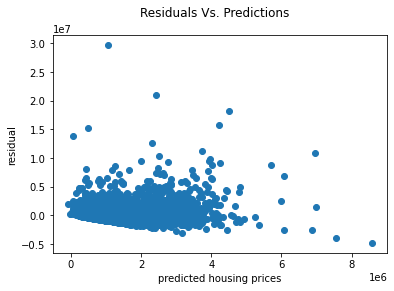

In [55]:
model_preds = base_results.predict(sm.add_constant(X))
# resid = error (differecne from real points (y) to predict points (preds))
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted housing prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

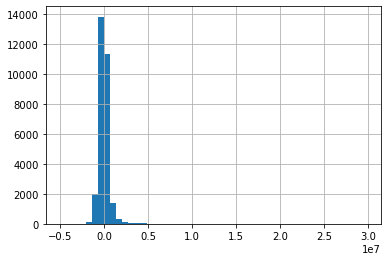

In [56]:

resids.hist(bins=50);

In [ ]:
# To eliminate the outliers from the plot we might try zooming in on the center:
resids[abs(resids) < 3500000].hist(bins=30);

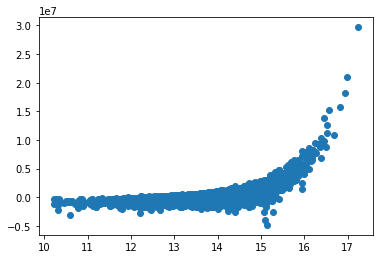

In [148]:
fig, ax = plt.subplots()
ax.scatter(y_scld, resids);

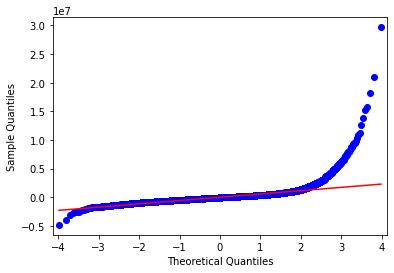

In [139]:
sm.qqplot(resids, line='r');

## Transforming our target (price)
We saw from our histogram of price it was very right skewed and so by taking the natural log, we will improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.

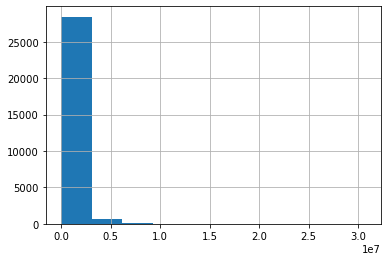

In [57]:
y.hist();

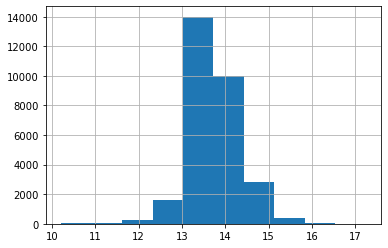

In [58]:
y_scld = np.log(y)
y_scld.hist();

In [60]:
# Improved simple regression (baseline) after transforming our target
X = clean_houses[['sqft_living']]

base_model_scld = sm.OLS(endog=y_scld, exog=sm.add_constant(X))
base_results_scld = base_model_scld.fit()
base_results_scld.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 1.870e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:20:52   Log-Likelihood:                -18636.
No. Observations:               29244   AIC:                         3.728e+04
Df Residuals:                   29242   BIC:                         3.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9398      0.006   2015.900      0.000      12.927      12.952
sqft_living     0.0004   2.74e-06    136.741      0.000       0.000       0.000
==============================================================================
Omnibus:                     5809.043   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45229.479
Skew:                          -0.745   Prob(JB):                         0.00
Kurtosis:                       8.907   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing all variables to figure out which variables we should keep

In [ ]:
# y = clean_houses['price']
# y_scld = np.log(y)

In [149]:
# finding the median price of houses for each grade

clean_houses.groupby('grade').median()['price'].sort_values()

grade
2 Substandard                       302,500.00
3 Poor                              400,000.00
4 Low                               470,000.00
5 Fair                              500,000.00
6 Low Average                       575,000.00
7 Average                           750,000.00
8 Good                              950,000.00
1 Cabin                           1,352,500.00
9 Better                          1,499,950.00
10 Very Good                      2,180,000.00
11 Excellent                      2,950,000.00
12 Luxury                         3,850,000.00
13 Mansion                        6,199,000.00
Name: price, dtype: float64

In [ ]:

cat_grd_df = clean_houses[[‘price’,‘sqft_living’,‘grade’]]
cat_grd_df = pd.get_dummies(cat_grd_df,columns=[‘grade’],prefix=‘grd’)


#Dropping most frequent
cat_grd_df.drop(columns=[‘grd_13 Mansion’,‘price’],axis=1,inplace=True)
testdf_model = sm.OLS(endog=y, exog=sm.add_constant(cat_grd_df))
testdf_results = testdf_model.fit()
testdf_results.summary()

In [26]:
# finding the median price of houses for each zipcode

clean_houses.groupby('zipcode').median()['price'].sort_values()

zipcode
98224     226000.0
98422     312750.0
98288     380000.0
98002     470000.0
98047     500000.0
           ...    
98223    2077000.0
98270    2375000.0
98040    2394000.0
98004    3100000.0
98039    4200000.0
Name: price, Length: 92, dtype: float64

In [101]:
pd.options.display.float_format = '{:30,.2f}'.format

In [62]:
# making a dataframe with column of interest dummied out
cat_zip_df = clean_houses[['price','sqft_living','zipcode']]
cat_zip_df = pd.get_dummies(cat_zip_df,columns=['zipcode'])

# dropping the zipcode with the highest median price
cat_zip_df.drop(columns=['zipcode_98039','price'],axis=1,inplace=True)

testzip_model = sm.OLS(endog=y_scld, exog=sm.add_constant(cat_zip_df))
testzip_results = testzip_model.fit()
testzip_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     622.8
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:22:48   Log-Likelihood:                -9969.7
No. Observations:               29244   AIC:                         2.013e+04
Df Residuals:                   29151   BIC:                         2.090e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.2125      0.045    314.766      0.000      14.124      14.301
sqft_living       0.0003   2.26e-06    133.266      0.000       0.000       0.000
zipcode_98001    -1.5512      0.047    -33.305      0.000      -1.643      -1.460
zipcode_98002    -1.6574      0.048    -34.472      0.000      -1.752      -1.563
zipcode_98003    -1.5651      0.047    -33.009      0.000      -1.658      -1.472
zipcode_98004    -0.3015      0.048     -6.246      0.000      -0.396      -0.207
zipcode_98005    -0.5764      0.051    -11.266      0.000      -0.677      -0.476
zipcode_98006    -0.7416      0.047    -15.837      0.000      -0.833      -0.650
zipcode_98007    -0.7908      0.052    -15.123      0.000      -0.893      -0.688
zipcode_98008    -0.7299      0.048    -15.309      0.000      -0.823      -0.636
zipcode_98010    -1.4211      0.048    -29.353      0.000      -1.516      -1.326
zipcode_98011    -0.9860      0.049    -20.038      0.000      -1.082      -0.890
zipcode_98014    -1.2238      0.052    -23.488      0.000      -1.326      -1.122
zipcode_98019    -1.1697      0.050    -23.628      0.000      -1.267      -1.073
zipcode_98022    -1.4965      0.047    -31.636      0.000      -1.589      -1.404
zipcode_98023    -1.5490      0.046    -33.409      0.000      -1.640      -1.458
zipcode_98024    -0.9447      0.055    -17.264      0.000      -1.052      -0.837
zipcode_98027    -0.9432      0.048    -19.757      0.000      -1.037      -0.850
zipcode_98028    -1.0805      0.048    -22.472      0.000      -1.175      -0.986
zipcode_98029    -0.8042      0.048    -16.634      0.000      -0.899      -0.709
zipcode_98030    -1.5208      0.048    -31.776      0.000      -1.615      -1.427
zipcode_98031    -1.5068      0.047    -32.104      0.000      -1.599      -1.415
zipcode_98032    -1.5273      0.051    -29.842      0.000      -1.628      -1.427
zipcode_98033    -0.5630      0.047    -12.094      0.000      -0.654      -0.472
zipcode_98034    -0.8800      0.046    -18.980      0.000      -0.971      -0.789
zipcode_98038    -1.3417      0.046    -29.173      0.000      -1.432      -1.252
zipcode_98040    -0.5116      0.048    -10.663      0.000      -0.606      -0.418
zipcode_98042    -1.4949      0.046    -32.634      0.000      -1.585      -1.405
zipcode_98045    -1.1618      0.047    -24.635      0.000      -1.254      -1.069
zipcode_98047    -1.6175      0.059    -27.419      0.000      -1.733      -1.502
zipcode_98050    -0.9332      0.245     -3.808      0.000      -1.413      -0.453
zipcode_98051    -1.3404      0.061    -22.005      0.000      -1.460      -1.221
zipcode_98052    -0.7302      0.047    -15.632      0.000      -0.822      -0.639
zipcode_98053    -0.8728      0.048    -18.322      0.000      -0.966      -0.779
zipcode_98055    -1.4325      0.050    -28.570   

In [46]:
# test = pd.DataFrame(testzip_results.params)

In [49]:
# test[0]['zipcode_98223']

664618.3485562747

### Dropping the columns we don't need

In [78]:
# Dropping columns with low individual R^2
clean_houses = clean_houses.drop(columns=['date','sqft_above','sqft_basement','sqft_garage','sqft_patio',
                                              'sqft_lot','waterfront','greenbelt','nuisance','condition',
                                              'heat_source','sewer_system','state','yr_built',
                                              'yr_renovated','address','lat','long','floors', 'city'])

In [79]:
clean_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29244 entries, 0 to 30154
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           29244 non-null  int64  
 1   price        29244 non-null  float64
 2   bedrooms     29244 non-null  int64  
 3   bathrooms    29244 non-null  float64
 4   sqft_living  29244 non-null  int64  
 5   view         29244 non-null  object 
 6   grade        29244 non-null  object 
 7   zipcode      29244 non-null  object 
 8   yr_sold      29244 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 2.2+ MB


In [23]:
#clean_houses.loc[clean_houses['id'] == 1233100736]
#checking to make sure that the duplicate is gone

In [22]:
#Rerunning the corr to see if anything has changed, whoops have to dummy many variables
#clean_houses.corr()

In [80]:
cat_df = pd.get_dummies(clean_houses,columns=['view','grade','zipcode'])

In [81]:
cat_df

,id,price,bedrooms,bathrooms,sqft_living,yr_sold,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
0,7399300360,"675,000.00",4,1.00,1180,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8910500230,"920,000.00",5,2.50,2770,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1180000275,"311,000.00",6,2.00,2880,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1604601802,"775,000.00",3,3.00,2160,2021,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8562780790,"592,500.00",2,2.00,1120,2021,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,"1,555,000.00",5,2.00,1910,2021,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30151,194000695,"1,313,000.00",3,2.00,2020,2021,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30152,7960100080,"800,000.00",3,2.00,1620,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30153,2781280080,"775,000.00",3,2.50,2570,2022,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
cat_df.drop(columns=['view_NONE', 'grade_13 Mansion', 'zipcode_98039'], inplace=True)

In [159]:
# Dropping grade 1 Cabin because as seen in the groupby price above, it is a misleading category
cat_df.drop(columns=['grade_1 Cabin'], inplace=True)

In [160]:
list(cat_df.columns)

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'yr_sold',
 'view_AVERAGE',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'grade_10 Very Good',
 'grade_11 Excellent',
 'grade_12 Luxury',
 'grade_2 Substandard',
 'grade_3 Poor',
 'grade_4 Low',
 'grade_5 Fair',
 'grade_6 Low Average',
 'grade_7 Average',
 'grade_8 Good',
 'grade_9 Better',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98047',
 'zipcode_98050',
 'zipcode_98051',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98057',
 'zipcode_9805

In [ ]:
"""
Talking about next steps, bar graph of yr sold as supporting visual.
Subset 2021 2022, avg sale price
Then subset into the zipcodes

"""

## Final Multiple Linear Regression model

In [161]:
X_final_3 = cat_df.drop(columns=['id', 'price', 'yr_sold'])

In [162]:
scaler = StandardScaler()

In [163]:
scaler.fit(X_final_3)

StandardScaler()

In [164]:
scaler.fit_transform(X_final_3)
X_final_3.describe()

,bedrooms,bathrooms,sqft_living,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,...,zipcode_98338,zipcode_98354,zipcode_98372,zipcode_98387,zipcode_98422,zipcode_98663,zipcode_99202,zipcode_99203,zipcode_99223,zipcode_99403
count,"29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00",...,"29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00","29,244.00"
mean,3.43,2.33,"2,130.59",0.06,0.02,0.01,0.03,0.05,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.98,0.90,977.32,0.25,0.14,0.09,0.17,0.21,0.12,0.06,...,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
min,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,2.00,"1,440.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.00,2.50,"1,940.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.00,3.00,"2,640.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,13.00,10.50,"15,360.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [165]:
final_model = sm.OLS(endog=y_scld, exog=sm.add_constant(X_final_3))
final_results = final_model.fit()
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:28:15   Log-Likelihood:                -8658.4
No. Observations:               29244   AIC:                         1.754e+04
Df Residuals:                   29134   BIC:                         1.845e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.3541      0.080    179.091      0.000      14.197      14.511
bedrooms                0.0067      0.003      2.422      0.015       0.001       0.012
bathrooms               0.0186      0.004      5.077      0.000       0.011       0.026
sqft_living             0.0002   4.24e-06     46.724      0.000       0.000       0.000
view_AVERAGE            0.1163      0.008     14.507      0.000       0.101       0.132
view_EXCELLENT          0.4618      0.015     31.561      0.000       0.433       0.490
view_FAIR               0.1662      0.023      7.366      0.000       0.122       0.210
view_GOOD               0.1750      0.012     15.027      0.000       0.152       0.198
grade_10 Very Good      0.1573      0.066      2.378      0.017       0.028       0.287
grade_11 Excellent      0.2367      0.067      3.532      0.000       0.105       0.368
grade_12 Luxury         0.1758      0.071      2.481      0.013       0.037       0.315
grade_2 Substandard    -0.8088      0.241     -3.359      0.001      -1.281      -0.337
grade_3 Poor           -0.5532      0.113     -4.888      0.000      -0.775      -0.331
grade_4 Low            -0.2338      0.082     -2.852      0.004      -0.394      -0.073
grade_5 Fair           -0.2244      0.070     -3.215      0.001      -0.361      -0.088
grade_6 Low Average    -0.1830      0.068     -2.695      0.007      -0.316      -0.050
grade_7 Average        -0.1143      0.067     -1.699      0.089      -0.246       0.018
grade_8 Good           -0.0273      0.067     -0.409      0.683      -0.158       0.104
grade_9 Better          0.1012      0.066      1.525      0.127      -0.029       0.231
zipcode_98001          -1.4774      0.045    -33.018      0.000      -1.565      -1.390
zipcode_98002          -1.5584      0.046    -33.754      0.000      -1.649      -1.468
zipcode_98003          -1.5122      0.046    -33.209      0.000      -1.601      -1.423
zipcode_98004          -0.2928      0.046     -6.329      0.000      -0.383      -0.202
zipcode_98005          -0.5626      0.049    -11.470      0.000      -0.659      -0.466
zipcode_98006          -0.7502      0.045    -16.699      0.000      -0.838      -0.662
zipcode_98007          -0.7308      0.050    -14.555      0.000      -0.829      -0.632
zipcode_98008          -0.7055      0.046    -15.406      0.000      -0.795      -0.616
zipcode_98010          -1.3642      0.047    -29.314      0.000      -1.455      -1.273
zipcode_98011          -0.9278      0.047    -19.626      0.000      -1.020      -0.835
zipcode_98014          -1.1647      0.050    -23.302      0.000      -1.263      -1.067
zipcode_98019          -1.1216      0.048    -23.586      0.000      -1.215      -1.028
zipcode_98022          -1.4506      0.045    -31.926      0.000      -1.540      -1.362
zip

## Checking our 4 Assumptions

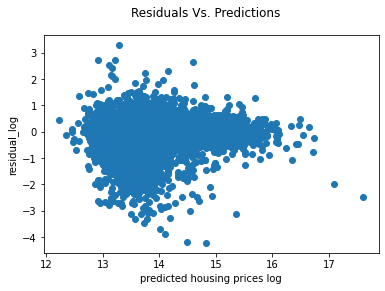

In [166]:
# linearity 

final_model_preds = final_results.predict(sm.add_constant(X_final_3))
# resid = error (differecne from real points (y) to predict points (preds))
final_resids = y_scld - final_model_preds

fig, ax = plt.subplots()

ax.scatter(final_model_preds, final_resids)
ax.set_xlabel('predicted housing prices log')
ax.set_ylabel('residual_log')
plt.suptitle('Residuals Vs. Predictions');

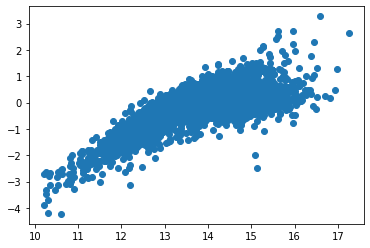

In [167]:
fig, ax = plt.subplots()

ax.scatter(y_scld, final_resids);

The Durbin-Watson test statistic is calculated on the null hypothesis that there is no correlation among the errors. The test statistic has a range of 0 to 4, where 2 indicates no correlation, a score less than 2 indicates a positive correlation, and a score greater than 2 indicates a negative correlation.

In [168]:
dw = sm.stats.stattools.durbin_watson
dw(final_resids)

1.9657634418557852

### Normality
The errors are normally distributed. That is, smaller errors are more probable than larger errors, according to the familiar bell curve. This is basically a conseqence of the Central Limit Theorem. If an error is a sum of influences from a large collection of (untracked!) variables, then the CLT assures us that that sum will have a normal distribution, regardless of the distributions of the untracked variables themselves.

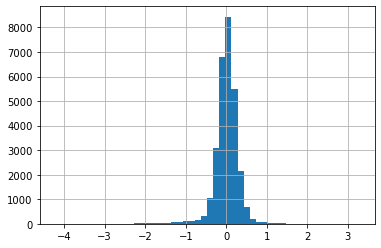

In [169]:
final_resids.hist(bins=50);

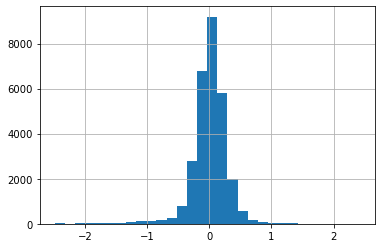

In [170]:
# To eliminate the outliers from the plot we might try zooming in on the center:
final_resids[abs(final_resids) < 2.5].hist(bins=30);

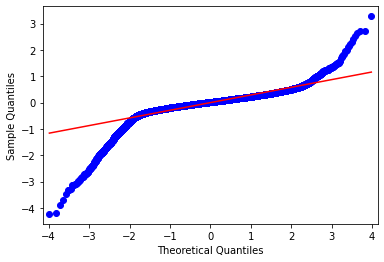

In [171]:
sm.qqplot(final_resids, line='r');

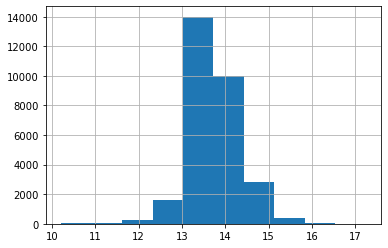

In [172]:
y_scld.hist();

In [141]:
np.exp(13)

442413.3920089205

### Homoskedasticity

Errors are homoskedatic = the errors have the same variance.

If errors are not homoskedastic, betas will have larger errors, leading to a greater risk of false negative conclusions about the significance of variables.

To check, make a scatter plot of the residuals and target values and look to see if they are more or less spread out at different places

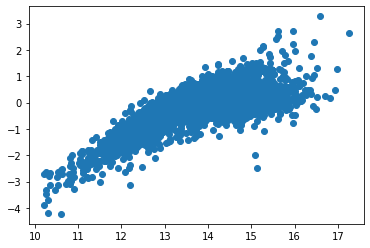

In [173]:
fig, ax = plt.subplots()

ax.scatter(y_scld, final_resids);

In [ ]:
sm.graphics.plot_regress_exog(final_results, 'X_final_1', fig=plt.figure(figsize=(12, 8)));

## Interpreting our coeficients for our final MLR

In [112]:
p_value = []
for x in range (0, 114):
    p_value.append(final_results.pvalues[x])

p_value

[0.0,
 0.014660372581284185,
 4.0247393583308455e-07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00030931985385244454,
 0.0,
 1.4411451653050067e-308,
 1.2356701167069918e-171,
 5.717312149112604e-41,
 0.6102005000955151,
 3.0786104192296284e-05,
 5.34132076868849e-43,
 1.051638409146082e-116,
 1.3645288547650446e-167,
 3.804795707641815e-209,
 4.904701012073881e-257,
 0.0,
 6.24252409712564e-54,
 1.8471000620796316e-64,
 6.896015798625047e-56,
 0.0,
 2.1783927870398665e-126,
 2.985974203739344e-134,
 3.909759481538933e-62,
 3.8400323749025953e-137,
 4.355625129523638e-13,
 2.053259786107879e-33,
 0.13514540453228133,
 0.00032014513341926097,
 3.719472515150605e-37,
 7.559524964247504e-68,
 1.1099160617551707e-21,
 5.374842306642418e-47,
 3.878489202407658e-19,
 2.2313312167655772e-76,
 4.44444375956937e-33,
 6.719802822893022e-36,
 3.4621372388656075e-21,
 0.0,
 1.8002444468712226e-110,
 1.3420136579162778e-05,
 1.8635856466486424e-164,
 2.9639573972235778e-208,
 1.0059236549967182e-44,
 

In [93]:
final_results.params

const                          10.34
bedrooms                        0.01
bathrooms                       0.02
sqft_living                     0.00
view_AVERAGE                    2.00
                        ...         
zipcode_98663                  -0.07
zipcode_99202                   0.17
zipcode_99203                   0.11
zipcode_99223                   0.19
zipcode_99403                   0.15
Length: 114, dtype: float64

In [110]:
mlr_stats = pd.DataFrame(final_results.params, columns=['coef'])
mlr_stats

,coef
const,10.34
bedrooms,0.01
bathrooms,0.02
sqft_living,0.00
view_AVERAGE,2.00
...,...
zipcode_98663,-0.07
zipcode_99202,0.17
zipcode_99203,0.11
zipcode_99223,0.19


In [113]:
mlr_stats['p_value'] = p_value

In [121]:
mlr_stats.reset_index()

,index,coef,p_value,stat_sig
0,const,10.34,0.00,True
1,bedrooms,0.01,0.01,True
2,bathrooms,0.02,0.00,True
3,sqft_living,0.00,0.00,True
4,view_AVERAGE,2.00,0.00,True
...,...,...,...,...
109,zipcode_98663,-0.07,0.76,False
110,zipcode_99202,0.17,0.60,False
111,zipcode_99203,0.11,0.72,False
112,zipcode_99223,0.19,0.56,False


In [116]:
mlr_stats['stat_sig']= mlr_stats['p_value'] < 0.05

For every one-unit increase in the independent variable, our dependent variable increases by about (coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9) 22%.

For every unit increase in sqft living, our price will increase by about 


In [124]:
while mlr_stats.index <5:
    for i in mlr_stats['index']:
        print(i)
    # print(f'For every unit increase in {mlr_stats.index[0:5]})

TypeError: '<' not supported between instances of 'str' and 'int'

In [118]:
mlr_stats.index

Index(['const', 'bedrooms', 'bathrooms', 'sqft_living', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE',
       'grade_1 Cabin',
       ...
       'zipcode_98338', 'zipcode_98354', 'zipcode_98372', 'zipcode_98387',
       'zipcode_98422', 'zipcode_98663', 'zipcode_99202', 'zipcode_99203',
       'zipcode_99223', 'zipcode_99403'],
      dtype='object', length=114)

- sqft living
- zipcode (top 10 most negative coef)

